# **AI-Powered Real-Time News Effects on Stock Market Changes**

**`Real_time Data Collection, Bert Embedding, Training Evaluation and Deployment `**

**Part 1: News Data Collection**

In [1]:

import requests
import pandas as pd
from datetime import datetime, timezone, timedelta
import time

# API Key and Tickers
API_KEY = "KMS8HGH09Y2Y8ZSM"
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX', 'IBM', 'AMD',
    'BA', 'JPM', 'V', 'PG', 'DIS', 'INTC', 'ORCL', 'CSCO', 'PEP', 'KO', 'XOM', 'WMT',
    'T', 'PFE', 'COST'
]
BASE_URL = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT"
all_articles = []

# Set date range: 30 days up to 1 hour ago
END_DATE = datetime.now(timezone.utc) - timedelta(hours=1)
START_DATE = END_DATE - timedelta(days=30)

def fetch_news(url, ticker="GENERAL", retries=3):
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Warning: Failed to fetch data for {ticker} (status {response.status_code})")
        except requests.RequestException as e:
            print(f"Error for {ticker}: {e}")
        time.sleep(0.5)
    print(f"Failed to fetch data for {ticker} after {retries} attempts")
    return {}

def fetch_daily_news(date, ticker="GENERAL", is_topic=False, max_articles=1000):
    articles_fetched = 0
    limit = 1000
    time_from = date.replace(hour=0, minute=0, second=0, microsecond=0)
    time_to = date.replace(hour=23, minute=59, second=59, microsecond=999999)
    offset = 0
    url = f"{BASE_URL}&{'topics' if is_topic else 'tickers'}={ticker}&time_from={time_from.strftime('%Y%m%dT%H%M')}&time_to={time_to.strftime('%Y%m%dT%H%M')}&limit={limit}&offset={offset}&apikey={API_KEY}"

    while articles_fetched < max_articles:
        data = fetch_news(url, ticker)
        articles = data.get("feed", [])
        if not articles:
            break
        for article in articles:
            try:
                # Parse the published time
                article_time = datetime.strptime(article["time_published"], "%Y%m%dT%H%M%S").replace(tzinfo=timezone.utc)
                if not (time_from <= article_time <= time_to):
                    continue
                # Use ISO 8601 format with UTC offset
                human_time = article_time.strftime("%Y-%m-%d %H:%M:%S+00:00")
            except (ValueError, TypeError) as e:
                print(f"Skipping article for {ticker} due to invalid time_published: {article.get('time Published', 'N/A')}")
                continue
            all_articles.append({
                "Ticker": ticker,
                "Title": article.get("title", "N/A"),
                "URL": article.get("url", "N/A"),
                "Time Published": article.get("time_published", "N/A"),
                "Article Time": article_time,
                "Timestamp": human_time,
            })
            articles_fetched += 1
            if articles_fetched >= max_articles:
                break
        print(f"Fetched {articles_fetched} articles for {ticker} on {date.date()}")
        time.sleep(0.1)
        if len(articles) < limit:
            break
        offset += limit
        url = f"{BASE_URL}&{'topics' if is_topic else 'tickers'}={ticker}&time_from={time_from.strftime('%Y%m%dT%H%M')}&time_to={time_to.strftime('%Y%m%dT%H%M')}&limit={limit}&offset={offset}&apikey={API_KEY}"
    return articles_fetched

def save_to_csv(articles, filename="Daily_News_data.csv"):
    df = pd.DataFrame(articles)
    if not df.empty:
        df['Date'] = df['Article Time'].dt.date
        df.to_csv(filename, index=False)
        print(f"Saved {len(df)} records to {filename}")
    else:
        print("No data to save")

# Fetch news data
current_date = START_DATE
total_articles = 0

try:
    while current_date <= END_DATE:
        print(f"\nProcessing date: {current_date.date()}")
        for ticker in TICKERS:
            total_articles += fetch_daily_news(current_date, ticker, is_topic=False, max_articles=1000)
        topics = ["business", "finance", "technology", "world"]
        for topic in topics:
            total_articles += fetch_daily_news(current_date, topic, is_topic=True, max_articles=1000)
        save_to_csv(all_articles)
        current_date += timedelta(days=1)

except KeyboardInterrupt:
    print("\nInterrupted by user. Saving collected data...")
    save_to_csv(all_articles)
    print(f"Total articles fetched before interruption: {total_articles}")

save_to_csv(all_articles)
print(f"Total articles fetched: {total_articles}")

# Load DataFrame for next part
all_articles_df = pd.DataFrame(all_articles)


Processing date: 2025-03-27
Fetched 12 articles for AAPL on 2025-03-27
Fetched 28 articles for MSFT on 2025-03-27
Fetched 11 articles for AMZN on 2025-03-27
Fetched 37 articles for TSLA on 2025-03-27
Fetched 66 articles for META on 2025-03-27
Fetched 52 articles for NVDA on 2025-03-27
Fetched 9 articles for NFLX on 2025-03-27
Fetched 2 articles for IBM on 2025-03-27
Fetched 9 articles for AMD on 2025-03-27
Fetched 9 articles for BA on 2025-03-27
Fetched 4 articles for V on 2025-03-27
Fetched 2 articles for PG on 2025-03-27
Fetched 1 articles for DIS on 2025-03-27
Fetched 7 articles for INTC on 2025-03-27
Fetched 3 articles for ORCL on 2025-03-27
Fetched 1 articles for CSCO on 2025-03-27
Fetched 4 articles for PEP on 2025-03-27
Fetched 4 articles for KO on 2025-03-27
Fetched 2 articles for XOM on 2025-03-27
Fetched 12 articles for WMT on 2025-03-27
Fetched 2 articles for T on 2025-03-27
Fetched 4 articles for PFE on 2025-03-27
Fetched 3 articles for COST on 2025-03-27
Fetched 945 artic

In [2]:
all_articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48093 entries, 0 to 48092
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Ticker          48093 non-null  object             
 1   Title           48093 non-null  object             
 2   URL             48093 non-null  object             
 3   Time Published  48093 non-null  object             
 4   Article Time    48093 non-null  datetime64[ns, UTC]
 5   Timestamp       48093 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 2.2+ MB


In [3]:
all_articles_df.head()

,Ticker,Title,URL,Time Published,Article Time,Timestamp
0,AAPL,Competitor Analysis: Evaluating Apple And Comp...,https://www.benzinga.com/insights/news/25/03/4...,20250327T150057,2025-03-27 15:00:57+00:00,2025-03-27 15:00:57+00:00
1,AAPL,Prediction: Apple Will Soar Over the Next 5 Ye...,https://www.fool.com/investing/2025/03/27/pred...,20250327T144237,2025-03-27 14:42:37+00:00,2025-03-27 14:42:37+00:00
2,AAPL,How To Trade SPY With Initial Jobless Claims I...,https://www.benzinga.com/markets/equities/25/0...,20250327T135059,2025-03-27 13:50:59+00:00,2025-03-27 13:50:59+00:00
3,AAPL,Can the Tide Turn for 'Magnificent Seven' Stoc...,https://www.zacks.com/stock/news/2436001/can-t...,20250327T120000,2025-03-27 12:00:00+00:00,2025-03-27 12:00:00+00:00
4,AAPL,Is Nvidia the Next $5 Trillion Stock? Or Will ...,https://www.fool.com/investing/2025/03/27/is-n...,20250327T103000,2025-03-27 10:30:00+00:00,2025-03-27 10:30:00+00:00


**Part 2: Stock Data Collection**

In [4]:
# Part 2: Stock Data Collection
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
import logging

# Set up logging
logging.basicConfig(filename="stock_data_log.log", level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Suppress yfinance errors from printing to console
yf_logger = logging.getLogger('yfinance')
yf_logger.setLevel(logging.ERROR)
yf_handler = logging.FileHandler('stock_data_log.log')
yf_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
yf_logger.addHandler(yf_handler)

TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX', 'IBM', 'AMD',
    'BA', 'JPM', 'V', 'PG', 'DIS', 'INTC', 'ORCL', 'CSCO', 'PEP', 'KO', 'XOM', 'WMT',
    'T', 'PFE', 'COST'
]

def get_intraday_stock_data(tickers, start_date, end_date, interval="5m"):
    stock_data = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date, interval=interval)
            if not hist.empty:
                for timestamp, row in hist.iterrows():
                    stock_data.append({
                        "Ticker": ticker,
                        "Timestamp": timestamp,
                        "Open": row["Open"],
                        "High": row["High"],
                        "Low": row["Low"],
                        "Close": row["Close"],
                        "Volume": row["Volume"]
                    })
                logging.info(f"Fetched {len(hist)} 1-min records for {ticker} "
                             f"({start_date.date()} to {end_date.date()})")
        except Exception as e:
            logging.error(f"Error fetching data for {ticker}: {str(e)}")
        time.sleep(1)  # Rate limiting
    df = pd.DataFrame(stock_data)
    if not df.empty:
        df["Timestamp"] = pd.to_datetime(df["Timestamp"]).dt.floor("min")
        df = df.sort_values(by=["Timestamp", "Ticker"])
    return df

# Define time range for the last 30 days
END_DATE = datetime.now(timezone.utc) - timedelta(hours=1)  # One hour ago
START_DATE = END_DATE - timedelta(days=30)  # 30 days prior

# Fetch data for the last 30 days
df_stock = get_intraday_stock_data(TICKERS, START_DATE, END_DATE, interval="5m")
logging.info(f"Total data: {len(df_stock)} records")

# Save the data
if not df_stock.empty:
    df_stock = df_stock.sort_values(by=["Timestamp", "Ticker"])
    df_stock.to_csv("stock_data_1min.csv", index=False)
    print(f"\nStock data saved to stock_data_1min.csv with {len(df_stock)} records")
else:
    print("\nNo data collected. Check logs for details.")
    logging.error("No data collected.")


Stock data saved to stock_data_1min.csv with 40725 records


In [5]:
# Display the first 5 rows of the combined DataFrame
print("\nPreview of combined stock data:")
df_stock.head()


Preview of combined stock data:


,Ticker,Timestamp,Open,High,Low,Close,Volume
0,AAPL,2025-03-27 10:10:00-04:00,221.210007,221.475006,220.809998,221.274994,0.0
14661,AMD,2025-03-27 10:10:00-04:00,106.029999,106.599998,105.650002,106.455002,0.0
4887,AMZN,2025-03-27 10:10:00-04:00,201.600006,202.109894,201.235001,202.033096,0.0
16290,BA,2025-03-27 10:10:00-04:00,180.199997,180.760406,179.750000,180.330002,0.0
39096,COST,2025-03-27 10:10:00-04:00,936.394470,938.489990,936.309998,937.270020,0.0


In [6]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40725 entries, 0 to 34208
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   Ticker     40725 non-null  object                          
 1   Timestamp  40725 non-null  datetime64[ns, America/New_York]
 2   Open       40725 non-null  float64                         
 3   High       40725 non-null  float64                         
 4   Low        40725 non-null  float64                         
 5   Close      40725 non-null  float64                         
 6   Volume     40725 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), object(1)
memory usage: 2.5+ MB


**Part 3: Data Merging and Preprocessing (within a 3-hour window )**

In [7]:
# Part 3: Data Merging and Preprocessing
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import spacy
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
from IPython.display import display
from tqdm import tqdm
import os

# Function to preprocess and fix malformed day values
def fix_malformed_timestamps(series):
    def correct_day(timestamp):
        if isinstance(timestamp, str) and '-d ' in timestamp:
            return timestamp.replace('-d ', '-01 ')
        return timestamp
    return series.apply(correct_day)

# Preprocess Timestamp column to fix malformed days
all_articles_df['Timestamp'] = fix_malformed_timestamps(all_articles_df['Timestamp'])
df_stock['Timestamp'] = fix_malformed_timestamps(df_stock['Timestamp'])

# Convert timestamps to datetime with UTC, with robust error handling
def safe_to_datetime(series, format_str="%Y-%m-%d %H:%M:%S%z"):
    try:
        result = pd.to_datetime(series, format=format_str, errors='coerce', utc=True)
        invalid_count = result.isna().sum()
        if invalid_count > 0:
            print(f"Warning: {invalid_count} invalid timestamps found with {format_str}, attempting fallback parsing")
            result = pd.to_datetime(series, errors='coerce', utc=True)
            invalid_count = result.isna().sum()
            if invalid_count > 0:
                print(f"Warning: {invalid_count} timestamps still invalid after fallback parsing")
                invalid_timestamps = series[result.isna()].head(5)
                print(f"Sample invalid timestamps: {invalid_timestamps.tolist()}")
        return result
    except Exception as e:
        print(f"Error parsing timestamps: {e}")
        return pd.to_datetime(series, errors='coerce', utc=True)

# Apply safe datetime conversion
all_articles_df['Timestamp'] = safe_to_datetime(all_articles_df['Timestamp'])
df_stock['Timestamp'] = safe_to_datetime(df_stock['Timestamp'])

# Drop rows with invalid timestamps
all_articles_df = all_articles_df.dropna(subset=['Timestamp'])
df_stock = df_stock.dropna(subset=['Timestamp'])
print(f"After dropping invalid timestamps: {len(all_articles_df)} news records, {len(df_stock)} stock records")

# Sort by Timestamp and Ticker
all_articles_df = all_articles_df.sort_values(['Ticker', 'Timestamp'])
df_stock = df_stock.sort_values(['Ticker', 'Timestamp'])

# Function for news articles within a 3-hour window
def merge_news_within_window(df, window_hours=3):
# Fetches news articles within a 3-hour window per ticker and timestamp, combining titles into 'Combined_Title'.
# Essential for Part 4 training, using 3-hour news data (e.g., 09:00:00–12:00:00 for 12:00:00 UTC) to capture
# recent impact of each news on stock price prediction at each timestamp.
    merged_news = []
    unique_timestamps = df.groupby(['Ticker', 'Timestamp']).first().reset_index()[['Ticker', 'Timestamp']]

    for _, row in unique_timestamps.iterrows():
        ticker = row['Ticker']
        timestamp = row['Timestamp']
        time_start = timestamp - pd.Timedelta(hours=window_hours)
        window_news = df[(df['Ticker'] == ticker) &
                         (df['Timestamp'] >= time_start) &
                         (df['Timestamp'] <= timestamp)]
        combined_title = " ".join(window_news['Title'].astype(str))
        merged_news.append({
            'Ticker': ticker,
            'Timestamp': timestamp,
            'Combined_Title': combined_title,
            'URL': window_news['URL'].iloc[-1] if not window_news.empty else 'N/A',
            'Time_Published': window_news['Time Published'].iloc[-1] if not window_news.empty else 'N/A'
        })

    return pd.DataFrame(merged_news)

# Merge news articles within a 3-hour window for training
merged_news_df = merge_news_within_window(all_articles_df, window_hours=3)
print(f"Merged news data: {len(merged_news_df)} records")

# Merge with stock data using merge_asof
merged_data = pd.merge_asof(
    merged_news_df.sort_values('Timestamp'),
    df_stock.sort_values('Timestamp'),
    by='Ticker',
    on='Timestamp',
    direction='nearest',
    tolerance=pd.Timedelta('10min')
)
# The merge_asof aligns each news record (with 3-hour Combined_Title) to the nearest stock
# Drop rows with missing stock data
merged_data = merged_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# Select and reorder columns
merged_data = merged_data[['Ticker', 'Combined_Title', 'URL', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Initialize spaCy and stopwords
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Clean text function
def clean_text(text):
    if not isinstance(text, str):
        return "no news available"
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    cleaned = " ".join(words)
    return cleaned if cleaned else "no news available"

# Apply cleaning to Combined_Title
merged_data['cleaned_title'] = merged_data['Combined_Title'].apply(clean_text)

# Initialize BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)
bert_model.eval()

# Batch processing for BERT embeddings
def get_bert_embedding_batch(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
        batch_texts = texts[i:i + batch_size]
        try:
            # Tokenize batch
            tokens = tokenizer(
                batch_texts.tolist(),
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)
            with torch.no_grad():
                outputs = bert_model(**tokens)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)
            print(f"Processed batch {i // batch_size + 1}: {len(batch_texts)} texts, {len(batch_embeddings)} embeddings")
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}: {e}")
            # Append None for failed texts
            batch_embeddings = [None] * len(batch_texts)
            embeddings.extend(batch_embeddings)
            print(f"Assigned {len(batch_texts)} None embeddings for failed batch")
        # Clear GPU memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    # Validate total embeddings
    print(f"Total texts: {len(texts)}, Total embeddings: {len(embeddings)}")
    if len(embeddings) != len(texts):
        raise ValueError(f"Embedding count ({len(embeddings)}) does not match text count ({len(texts)})")
    return embeddings

# Apply BERT embeddings with checkpointing
checkpoint_file = "merged_data_partial_embeddings.pkl"
batch_size = 32
try:
    if os.path.exists(checkpoint_file):
        print(f"Resuming from checkpoint: {checkpoint_file}")
        merged_data = pd.read_pickle(checkpoint_file)
        # Validate bert_embedding column
        if 'bert_embedding' not in merged_data.columns:
            merged_data['bert_embedding'] = pd.Series([None] * len(merged_data), dtype=object)
        else:
            # Reset bert_embedding if it contains inconsistent types
            merged_data['bert_embedding'] = merged_data['bert_embedding'].apply(
                lambda x: x if isinstance(x, np.ndarray) or x is None else None
            )
    else:
        # Initialize bert_embedding as object dtype
        merged_data['bert_embedding'] = pd.Series([None] * len(merged_data), dtype=object)

    # Process only rows without embeddings
    missing_indices = merged_data[merged_data['bert_embedding'].isna()].index
    if len(missing_indices) > 0:
        print(f"Processing {len(missing_indices)} records for BERT embeddings")
        embeddings = get_bert_embedding_batch(
            merged_data.loc[missing_indices, 'cleaned_title'],
            batch_size=batch_size
        )
        # Convert embeddings to a list of arrays, replacing None with None
        embeddings_list = [np.array(emb) if emb is not None else None for emb in embeddings]
        print(f"Embeddings list length: {len(embeddings_list)}, Shape of first embedding: {embeddings_list[0].shape if embeddings_list[0] is not None else 'None'}")
        # Validate lengths before assignment
        if len(embeddings_list) != len(missing_indices):
            raise ValueError(
                f"Length mismatch: {len(embeddings_list)} embeddings for {len(missing_indices)} indices"
            )
        # Assign embeddings using a temporary Series
        print("Assigning embeddings to DataFrame...")
        embedding_series = pd.Series(embeddings_list, index=missing_indices, dtype=object)
        for idx in missing_indices:
            emb = embedding_series.loc[idx]
            if emb is not None and not np.all(np.isnan(emb)):
                if emb.shape != (768,):
                    print(f"Warning: Invalid embedding shape at index {idx}: {emb.shape}")
                    embedding_series.loc[idx] = None
            if idx % 500 == 0:
                print(f"Validated embedding for index {idx}, shape: {emb.shape if emb is not None and not np.all(np.isnan(emb)) else 'None'}")
        merged_data['bert_embedding'].update(embedding_series)
        print(f"Completed embedding assignment for {len(missing_indices)} records")
        # Save checkpoint
        merged_data.to_pickle(checkpoint_file)
        print(f"Saved checkpoint to {checkpoint_file}")
    else:
        print("All records already have embeddings")

except KeyboardInterrupt:
    print("\nInterrupted during BERT embedding generation. Saving partial results...")
    merged_data.to_pickle(checkpoint_file)
    print(f"Saved partial results to {checkpoint_file}")
    raise
except Exception as e:
    print(f"Error during BERT embedding generation: {e}")
    merged_data.to_pickle(checkpoint_file)
    print(f"Saved partial results to {checkpoint_file}")
    raise

# Save final results
merged_data.to_pickle("merged_data_with_embeddings.pkl")
# The final merged_data_with_embeddings.pkl contains the 3-hour aggregated news data
print("Merged data with BERT embeddings saved.")




After dropping invalid timestamps: 48093 news records, 40725 stock records
Merged news data: 34229 records


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing 1971 records for BERT embeddings


Generating BERT embeddings:   2%|▏         | 1/62 [00:00<00:56,  1.08it/s]

Processed batch 1: 32 texts, 32 embeddings


Generating BERT embeddings:   3%|▎         | 2/62 [00:01<00:44,  1.34it/s]

Processed batch 2: 32 texts, 32 embeddings


Generating BERT embeddings:   5%|▍         | 3/62 [00:02<00:42,  1.38it/s]

Processed batch 3: 32 texts, 32 embeddings


Generating BERT embeddings:   6%|▋         | 4/62 [00:02<00:36,  1.60it/s]

Processed batch 4: 32 texts, 32 embeddings


Generating BERT embeddings:   8%|▊         | 5/62 [00:03<00:32,  1.76it/s]

Processed batch 5: 32 texts, 32 embeddings


Generating BERT embeddings:  10%|▉         | 6/62 [00:03<00:31,  1.78it/s]

Processed batch 6: 32 texts, 32 embeddings


Generating BERT embeddings:  11%|█▏        | 7/62 [00:04<00:28,  1.92it/s]

Processed batch 7: 32 texts, 32 embeddings


Generating BERT embeddings:  13%|█▎        | 8/62 [00:04<00:31,  1.72it/s]

Processed batch 8: 32 texts, 32 embeddings


Generating BERT embeddings:  15%|█▍        | 9/62 [00:05<00:34,  1.53it/s]

Processed batch 9: 32 texts, 32 embeddings


Generating BERT embeddings:  16%|█▌        | 10/62 [00:06<00:35,  1.47it/s]

Processed batch 10: 32 texts, 32 embeddings


Generating BERT embeddings:  18%|█▊        | 11/62 [00:07<00:34,  1.46it/s]

Processed batch 11: 32 texts, 32 embeddings


Generating BERT embeddings:  19%|█▉        | 12/62 [00:07<00:34,  1.44it/s]

Processed batch 12: 32 texts, 32 embeddings


Generating BERT embeddings:  21%|██        | 13/62 [00:08<00:32,  1.49it/s]

Processed batch 13: 32 texts, 32 embeddings


Generating BERT embeddings:  23%|██▎       | 14/62 [00:09<00:36,  1.32it/s]

Processed batch 14: 32 texts, 32 embeddings


Generating BERT embeddings:  24%|██▍       | 15/62 [00:10<00:39,  1.19it/s]

Processed batch 15: 32 texts, 32 embeddings


Generating BERT embeddings:  26%|██▌       | 16/62 [00:11<00:40,  1.14it/s]

Processed batch 16: 32 texts, 32 embeddings


Generating BERT embeddings:  27%|██▋       | 17/62 [00:11<00:33,  1.35it/s]

Processed batch 17: 32 texts, 32 embeddings


Generating BERT embeddings:  29%|██▉       | 18/62 [00:12<00:30,  1.44it/s]

Processed batch 18: 32 texts, 32 embeddings


Generating BERT embeddings:  31%|███       | 19/62 [00:13<00:28,  1.50it/s]

Processed batch 19: 32 texts, 32 embeddings


Generating BERT embeddings:  32%|███▏      | 20/62 [00:13<00:26,  1.59it/s]

Processed batch 20: 32 texts, 32 embeddings


Generating BERT embeddings:  34%|███▍      | 21/62 [00:14<00:26,  1.57it/s]

Processed batch 21: 32 texts, 32 embeddings


Generating BERT embeddings:  35%|███▌      | 22/62 [00:14<00:27,  1.48it/s]

Processed batch 22: 32 texts, 32 embeddings


Generating BERT embeddings:  37%|███▋      | 23/62 [00:15<00:25,  1.53it/s]

Processed batch 23: 32 texts, 32 embeddings


Generating BERT embeddings:  39%|███▊      | 24/62 [00:16<00:23,  1.63it/s]

Processed batch 24: 32 texts, 32 embeddings


Generating BERT embeddings:  40%|████      | 25/62 [00:16<00:21,  1.70it/s]

Processed batch 25: 32 texts, 32 embeddings


Generating BERT embeddings:  42%|████▏     | 26/62 [00:17<00:20,  1.74it/s]

Processed batch 26: 32 texts, 32 embeddings


Generating BERT embeddings:  44%|████▎     | 27/62 [00:17<00:20,  1.72it/s]

Processed batch 27: 32 texts, 32 embeddings


Generating BERT embeddings:  45%|████▌     | 28/62 [00:18<00:17,  1.91it/s]

Processed batch 28: 32 texts, 32 embeddings


Generating BERT embeddings:  47%|████▋     | 29/62 [00:18<00:16,  2.04it/s]

Processed batch 29: 32 texts, 32 embeddings


Generating BERT embeddings:  48%|████▊     | 30/62 [00:18<00:14,  2.16it/s]

Processed batch 30: 32 texts, 32 embeddings


Generating BERT embeddings:  50%|█████     | 31/62 [00:19<00:14,  2.15it/s]

Processed batch 31: 32 texts, 32 embeddings


Generating BERT embeddings:  52%|█████▏    | 32/62 [00:19<00:13,  2.16it/s]

Processed batch 32: 32 texts, 32 embeddings


Generating BERT embeddings:  53%|█████▎    | 33/62 [00:20<00:13,  2.08it/s]

Processed batch 33: 32 texts, 32 embeddings


Generating BERT embeddings:  55%|█████▍    | 34/62 [00:20<00:13,  2.05it/s]

Processed batch 34: 32 texts, 32 embeddings


Generating BERT embeddings:  56%|█████▋    | 35/62 [00:21<00:15,  1.79it/s]

Processed batch 35: 32 texts, 32 embeddings


Generating BERT embeddings:  58%|█████▊    | 36/62 [00:22<00:13,  1.87it/s]

Processed batch 36: 32 texts, 32 embeddings


Generating BERT embeddings:  60%|█████▉    | 37/62 [00:22<00:12,  1.93it/s]

Processed batch 37: 32 texts, 32 embeddings


Generating BERT embeddings:  61%|██████▏   | 38/62 [00:23<00:12,  1.95it/s]

Processed batch 38: 32 texts, 32 embeddings


Generating BERT embeddings:  63%|██████▎   | 39/62 [00:23<00:11,  2.00it/s]

Processed batch 39: 32 texts, 32 embeddings


Generating BERT embeddings:  65%|██████▍   | 40/62 [00:24<00:12,  1.77it/s]

Processed batch 40: 32 texts, 32 embeddings


Generating BERT embeddings:  66%|██████▌   | 41/62 [00:25<00:12,  1.65it/s]

Processed batch 41: 32 texts, 32 embeddings


Generating BERT embeddings:  68%|██████▊   | 42/62 [00:25<00:12,  1.54it/s]

Processed batch 42: 32 texts, 32 embeddings


Generating BERT embeddings:  69%|██████▉   | 43/62 [00:26<00:11,  1.71it/s]

Processed batch 43: 32 texts, 32 embeddings


Generating BERT embeddings:  71%|███████   | 44/62 [00:26<00:08,  2.01it/s]

Processed batch 44: 32 texts, 32 embeddings


Generating BERT embeddings:  73%|███████▎  | 45/62 [00:26<00:08,  2.03it/s]

Processed batch 45: 32 texts, 32 embeddings


Generating BERT embeddings:  74%|███████▍  | 46/62 [00:27<00:07,  2.03it/s]

Processed batch 46: 32 texts, 32 embeddings


Generating BERT embeddings:  76%|███████▌  | 47/62 [00:27<00:07,  2.05it/s]

Processed batch 47: 32 texts, 32 embeddings


Generating BERT embeddings:  77%|███████▋  | 48/62 [00:28<00:07,  1.89it/s]

Processed batch 48: 32 texts, 32 embeddings


Generating BERT embeddings:  79%|███████▉  | 49/62 [00:29<00:07,  1.83it/s]

Processed batch 49: 32 texts, 32 embeddings


Generating BERT embeddings:  81%|████████  | 50/62 [00:29<00:07,  1.66it/s]

Processed batch 50: 32 texts, 32 embeddings


Generating BERT embeddings:  82%|████████▏ | 51/62 [00:30<00:06,  1.57it/s]

Processed batch 51: 32 texts, 32 embeddings


Generating BERT embeddings:  84%|████████▍ | 52/62 [00:31<00:06,  1.55it/s]

Processed batch 52: 32 texts, 32 embeddings


Generating BERT embeddings:  85%|████████▌ | 53/62 [00:31<00:05,  1.60it/s]

Processed batch 53: 32 texts, 32 embeddings


Generating BERT embeddings:  87%|████████▋ | 54/62 [00:32<00:04,  1.76it/s]

Processed batch 54: 32 texts, 32 embeddings


Generating BERT embeddings:  89%|████████▊ | 55/62 [00:32<00:03,  1.91it/s]

Processed batch 55: 32 texts, 32 embeddings


Generating BERT embeddings:  90%|█████████ | 56/62 [00:33<00:02,  2.04it/s]

Processed batch 56: 32 texts, 32 embeddings


Generating BERT embeddings:  92%|█████████▏| 57/62 [00:33<00:02,  2.29it/s]

Processed batch 57: 32 texts, 32 embeddings


Generating BERT embeddings:  94%|█████████▎| 58/62 [00:33<00:01,  2.37it/s]

Processed batch 58: 32 texts, 32 embeddings


Generating BERT embeddings:  95%|█████████▌| 59/62 [00:34<00:01,  2.09it/s]

Processed batch 59: 32 texts, 32 embeddings


Generating BERT embeddings:  97%|█████████▋| 60/62 [00:35<00:01,  1.80it/s]

Processed batch 60: 32 texts, 32 embeddings


Generating BERT embeddings: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]

Processed batch 61: 32 texts, 32 embeddings
Processed batch 62: 19 texts, 19 embeddings
Total texts: 1971, Total embeddings: 1971
Embeddings list length: 1971, Shape of first embedding: (768,)
Assigning embeddings to DataFrame...
Validated embedding for index 4000, shape: (768,)
Validated embedding for index 5500, shape: (768,)


Validated embedding for index 20000, shape: (768,)
Validated embedding for index 24500, shape: (768,)
Validated embedding for index 26000, shape: (768,)
Completed embedding assignment for 1971 records
Saved checkpoint to merged_data_partial_embeddings.pkl
Merged data with BERT embeddings saved.


<ipython-input-7-3d87ee160304>:211: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['bert_embedding'].update(embedding_series)


In [8]:
# Display sample
print("Merged data sample:")
display(merged_data[['Ticker', 'Timestamp', 'Combined_Title', 'cleaned_title']].head())

Merged data sample:


,Ticker,Timestamp,Combined_Title,cleaned_title
598,META,2025-03-27 14:11:00+00:00,Worksport Ltd. Reports Fiscal Year 2024 Result...,worksport ltd report fiscal year result achi...
607,NVDA,2025-03-27 14:14:02+00:00,Intel Stock Could Soar If This Nvidia Rumor Is...,intel stock could soar nvidia rumor true aliba...
613,ORCL,2025-03-27 14:15:12+00:00,SoftBank May Want To Outdo Microsoft With $40 ...,softbank may want outdo microsoft billion in...
641,MSFT,2025-03-27 14:20:31+00:00,Intel Stock Could Soar If This Nvidia Rumor Is...,intel stock could soar nvidia rumor true tide ...
642,META,2025-03-27 14:20:31+00:00,Worksport Ltd. Reports Fiscal Year 2024 Result...,worksport ltd report fiscal year result achi...


In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1971 entries, 598 to 33518
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Ticker          1971 non-null   object             
 1   Combined_Title  1971 non-null   object             
 2   URL             1971 non-null   object             
 3   Timestamp       1971 non-null   datetime64[ns, UTC]
 4   Open            1971 non-null   float64            
 5   High            1971 non-null   float64            
 6   Low             1971 non-null   float64            
 7   Close           1971 non-null   float64            
 8   Volume          1971 non-null   float64            
 9   cleaned_title   1971 non-null   object             
 10  bert_embedding  1971 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 249.3+ KB


In [10]:
merged_data.head()

,Ticker,Combined_Title,URL,Timestamp,Open,High,Low,Close,Volume,cleaned_title,bert_embedding
598,META,Worksport Ltd. Reports Fiscal Year 2024 Result...,https://www.benzinga.com/pressreleases/25/03/n...,2025-03-27 14:11:00+00:00,608.090027,611.629883,607.500000,610.804993,0.0,worksport ltd report fiscal year result achi...,"[-0.033921186, -0.022007404, 0.49986544, -0.09..."
607,NVDA,Intel Stock Could Soar If This Nvidia Rumor Is...,https://www.cnbc.com/2025/03/27/nvidia-to-anch...,2025-03-27 14:14:02+00:00,112.900002,112.949997,112.529999,112.720001,2369532.0,intel stock could soar nvidia rumor true aliba...,"[-0.13673222, -0.07484961, 0.51462585, 0.09437..."
613,ORCL,SoftBank May Want To Outdo Microsoft With $40 ...,https://www.benzinga.com/insights/news/25/03/4...,2025-03-27 14:15:12+00:00,146.220001,146.220001,145.800003,145.919998,163016.0,softbank may want outdo microsoft billion in...,"[-0.16432855, -0.15324287, 0.33505094, 0.09381..."
641,MSFT,Intel Stock Could Soar If This Nvidia Rumor Is...,https://www.benzinga.com/media/25/03/44515782/...,2025-03-27 14:20:31+00:00,390.355011,390.390015,389.470001,389.809998,100402.0,intel stock could soar nvidia rumor true tide ...,"[-0.082031816, -0.13767207, 0.51585215, 0.1896..."
642,META,Worksport Ltd. Reports Fiscal Year 2024 Result...,https://www.benzinga.com/media/25/03/44515782/...,2025-03-27 14:20:31+00:00,610.575012,610.739990,608.000000,609.109985,117956.0,worksport ltd report fiscal year result achi...,"[-0.1324979, -0.048633885, 0.485454, -0.041105..."


**Part 4: Model Training**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Load and validate data
merged_data = pd.read_pickle("merged_data_with_embeddings.pkl")

# Check for invalid bert_embedding values
invalid_embeddings = merged_data['bert_embedding'].isna() | merged_data['bert_embedding'].apply(lambda x: x is None or not isinstance(x, np.ndarray) or x.shape != (768,))
print(f"Rows with invalid embeddings: {invalid_embeddings.sum()}")
if invalid_embeddings.sum() > 0:
    merged_data.loc[invalid_embeddings, 'bert_embedding'] = merged_data.loc[invalid_embeddings, 'bert_embedding'].apply(lambda x: np.zeros(768))
    print("Replaced invalid embeddings with zero vectors")

# Clip outliers in Close prices
lower_bound, upper_bound = np.percentile(merged_data['Close'], [5, 95])
merged_data['Close'] = merged_data['Close'].clip(lower=lower_bound, upper=upper_bound)
print(f"Clipped Close prices to range [{lower_bound:.2f}, {upper_bound:.2f}]")

# Prepare data with scaling
scaler_X = StandardScaler()
stock_features = scaler_X.fit_transform(merged_data[['Open', 'High', 'Low']].values)
bert_embeddings = np.stack(merged_data['bert_embedding'].values)  # Already normalized from BERT
X = np.concatenate([stock_features, bert_embeddings], axis=1)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(merged_data['Close'].values.reshape(-1, 1)).flatten()

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension for LSTM
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model definition
class NewsAndStockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(NewsAndStockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take the last time step
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = stock_features.shape[1] + bert_embeddings.shape[1]  # 3 + 768 = 771
model = NewsAndStockLSTM(input_size=input_size, hidden_size=512, num_layers=3, output_size=1).to(device)
print("Optimized News and Stock LSTM Model:")
print(model)

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20)
epochs = 200
best_val_loss = float('inf')
patience = 50
counter = 0

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

print("Training Optimized News and Stock LSTM Model...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_predictions = []
    train_actuals = []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
        # Inverse-transform predictions and actuals for R² and MSE
        pred_scaled = scaler_y.inverse_transform(predictions.detach().cpu().numpy())
        actual_scaled = scaler_y.inverse_transform(batch_y.detach().cpu().numpy())
        train_predictions.extend(pred_scaled.flatten())
        train_actuals.extend(actual_scaled.flatten())
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_r2 = r2_score(train_actuals, train_predictions)
    train_r2_scores.append(train_r2)
    train_mse_dollars = mean_squared_error(train_actuals, train_predictions)

    model.eval()
    val_loss = 0
    val_predictions = []
    val_actuals = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
            # Inverse-transform predictions and actuals for R² and MSE
            pred_scaled = scaler_y.inverse_transform(predictions.detach().cpu().numpy())
            actual_scaled = scaler_y.inverse_transform(batch_y.detach().cpu().numpy())
            val_predictions.extend(pred_scaled.flatten())
            val_actuals.extend(actual_scaled.flatten())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_r2 = r2_score(val_actuals, val_predictions)
    val_r2_scores.append(val_r2)
    val_mse_dollars = mean_squared_error(val_actuals, val_predictions)
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "news_and_stock_lstm_model_best.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, "
      f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Save final model
torch.save(model.state_dict(), "news_and_stock_lstm_model_final.pth")

print("Training completed!")

Rows with invalid embeddings: 0
Clipped Close prices to range [27.08, 927.50]
Optimized News and Stock LSTM Model:
NewsAndStockLSTM(
  (lstm): LSTM(771, 512, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Training Optimized News and Stock LSTM Model...
Epoch 10/200, Train Loss: 0.016333, Val Loss: 0.012893, Train R²: 0.9834, Val R²: 0.9883
Epoch 20/200, Train Loss: 0.020153, Val Loss: 0.003528, Train R²: 0.9795, Val R²: 0.9967
Epoch 30/200, Train Loss: 0.017528, Val Loss: 0.012168, Train R²: 0.9821, Val R²: 0.9886
Epoch 40/200, Train Loss: 0.009946, Val Loss: 0.002642, Train R²: 0.9899, Val R²: 0.9975
Epoch 50/200, Train Loss: 0.009994, Val Loss: 0.001774, Train R²: 0.9898, Val R²: 0.9983
Epoch 60/200, Train Loss: 0.010520, Val Loss: 0.002406, Tr

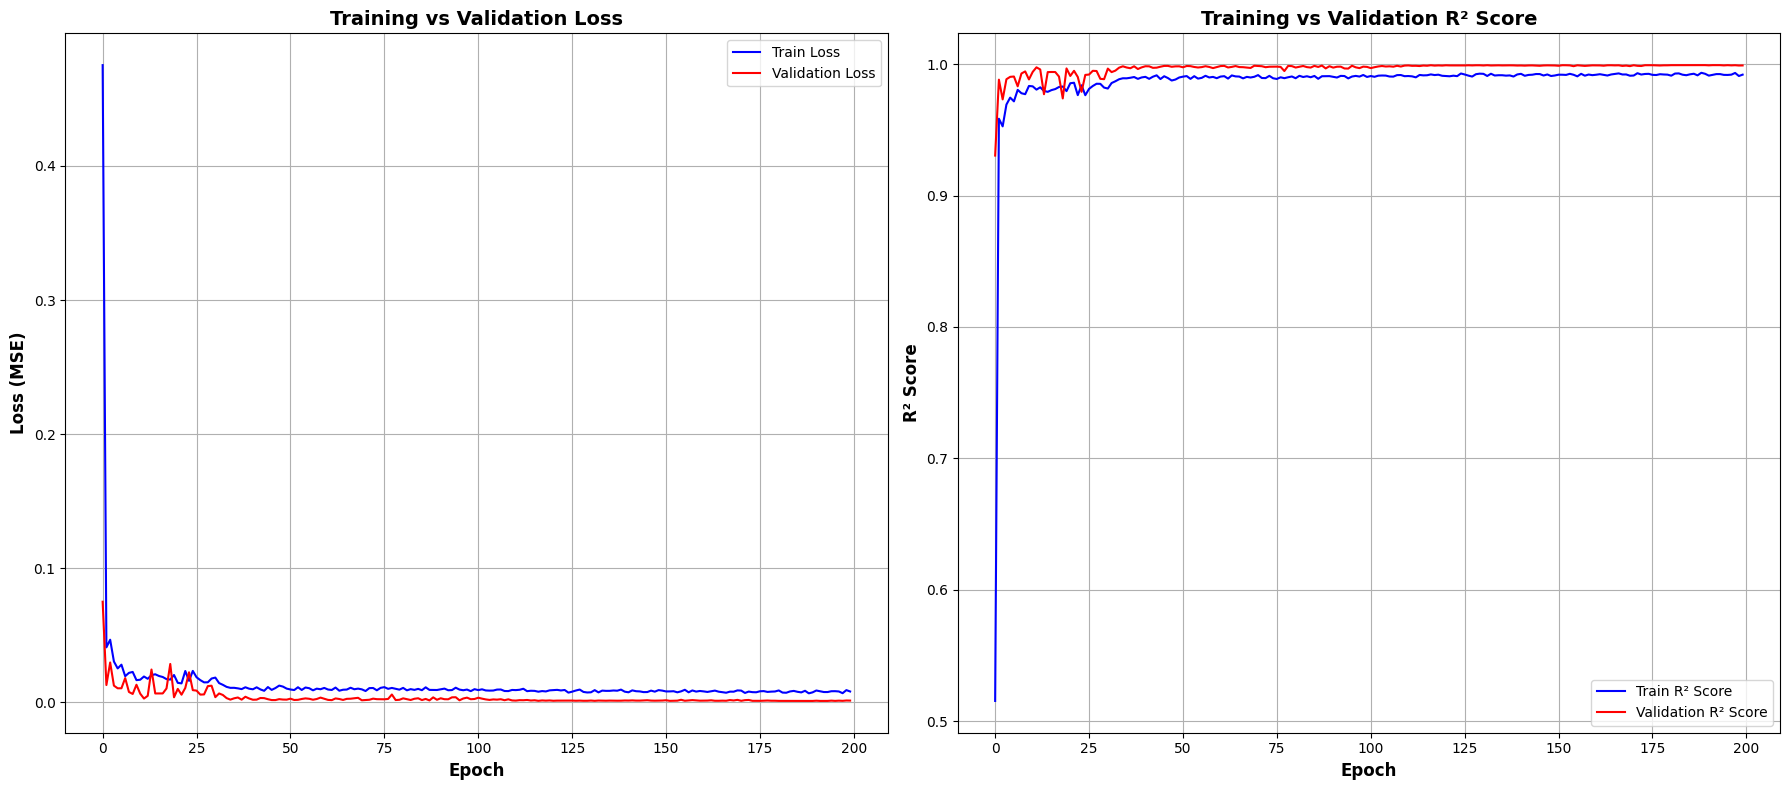

In [12]:

import matplotlib.pyplot as plt

# Create one figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# --- Loss Plot ---
axs[0].plot(train_losses, label='Train Loss', color='blue')
axs[0].plot(val_losses, label='Validation Loss', color='red')
axs[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axs[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axs[0].legend()
axs[0].grid(True)

# --- R² Score Plot ---
axs[1].plot(train_r2_scores, label='Train R² Score', color='blue')
axs[1].plot(val_r2_scores, label='Validation R² Score', color='red')
axs[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axs[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axs[1].set_title('Training vs Validation R² Score', fontsize=14, fontweight='bold')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('loss_r2_combined.png')
plt.show()



**Part 5: Model Evaluation and Visualization**

In [24]:
# Evaluate on test set
model.load_state_dict(torch.load("news_and_stock_lstm_model_final.pth"))
model.eval()
test_predictions = []
test_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        # Inverse-transform predictions and actuals to original scale
        pred_scaled = scaler_y.inverse_transform(predictions.detach().cpu().numpy())
        actual_scaled = scaler_y.inverse_transform(batch_y.detach().cpu().numpy())
        test_predictions.extend(pred_scaled.flatten())
        test_actuals.extend(actual_scaled.flatten())

# Calculate test metrics
test_mse_dollars = mean_squared_error(test_actuals, test_predictions)
test_r2 = r2_score(test_actuals, test_predictions)

print("\nTest Set Performance:")
print(f"\nTest MSE (in dollars²): {test_mse_dollars:.4f}")

print(f"Test Loss (MSE): {test_loss / len(test_loader):.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.4f}")




Test Set Performance:

Test MSE (in dollars²): 110.6427
Test Loss (MSE): 0.002034
Test RMSE: 0.046165
R² Score: 0.9978


In [25]:
# Create DataFrame for predictions vs actuals
results_df = pd.DataFrame({
    'Actual Close Price': test_actuals,
    'Predicted Close Price': test_predictions
})

# Display results
print("\nSample Predictions vs Actual Close Prices (Test Set):")
try:
    display(results_df.head(10).round(2))  # For Jupyter
except NameError:
    print(results_df.head(10).round(2))  # For non-Jupyter environments


Sample Predictions vs Actual Close Prices (Test Set):


,Actual Close Price,Predicted Close Price
0,249.070007,249.789993
1,27.080000,44.700001
2,171.800003,173.110001
3,27.080000,36.740002
4,105.110001,111.650002
5,323.750000,327.869995
6,112.279999,112.980003
7,231.830002,238.339996
8,927.500000,919.549988
9,128.279999,135.009995


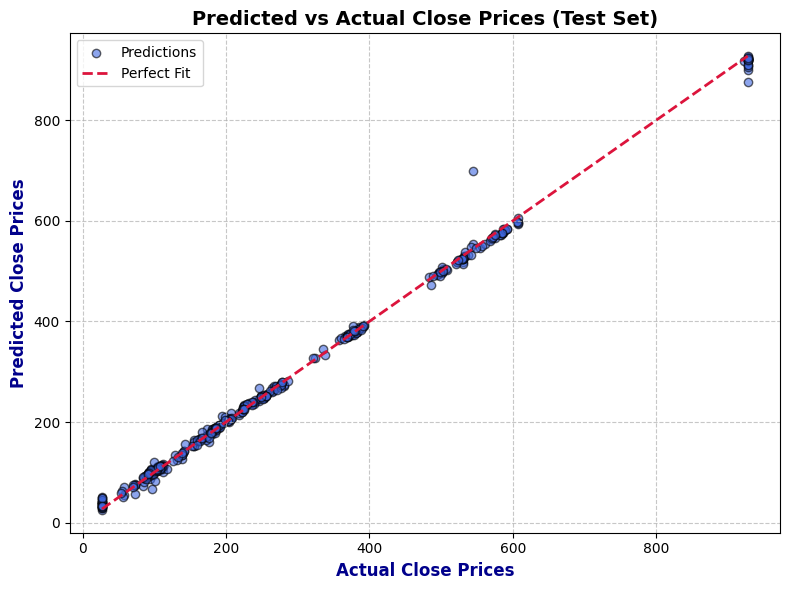

In [27]:
# Plot predictions vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(test_actuals, test_predictions, color='royalblue', alpha=0.6, edgecolor='black', label='Predictions')
plt.plot([min(test_actuals), max(test_actuals)], [min(test_actuals), max(test_actuals)],
         color='crimson', linestyle='--', linewidth=2, label='Perfect Fit')
plt.xlabel('Actual Close Prices', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Close Prices', fontsize=12, fontweight='bold', color='darkblue')
plt.title('Predicted vs Actual Close Prices (Test Set)', fontsize=14, fontweight='bold', color='black')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('predictions_plot.png')
plt.show()

# **Part 6: Deployment, Gradio Implementation**

In [28]:
!pip install gradio
!pip install schedule

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
import spacy
import re
from nltk.corpus import stopwords
import requests
import pandas as pd
from datetime import datetime, timezone, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
import os
import tempfile
import logging
import time
from sklearn.preprocessing import StandardScaler

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Load spaCy and stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Alpha Vantage API Key
API_KEY = "KMS8HGH09Y2Y8ZSM"
BASE_URL = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT"

# Load merged data for scalers
try:
    merged_data = pd.read_pickle("merged_data_with_embeddings.pkl")
    logging.info("Merged data loaded successfully")
except Exception as e:
    logging.error(f"Error loading merged data: {str(e)}")
    raise

# Initialize scalers
scaler_X = StandardScaler()
scaler_X.fit(merged_data[['Open', 'High', 'Low']].values)
scaler_y = StandardScaler()
scaler_y.fit(merged_data['Close'].values.reshape(-1, 1))

# Define LSTM model (matches Part 4)
class NewsAndStockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(NewsAndStockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Initialize model and BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = NewsAndStockLSTM(input_size=771, hidden_size=512, num_layers=3, output_size=1).to(device)
    model.load_state_dict(torch.load("news_and_stock_lstm_model_final.pth"))
    model.eval()
    logging.info("Model loaded successfully")
except Exception as e:
    logging.error(f"Error loading model: {str(e)}")
    raise

try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
    logging.info("BERT model loaded successfully")
except Exception as e:
    logging.error(f"Error loading BERT model: {str(e)}")
    raise

# Global variables
prediction_history = []
UPDATE_INTERVAL = 60  # 1 minute to avoid API rate limits; set to 60 with premium API key
last_stock_data = {}  # Cache for last successful stock data per ticker: {ticker: [open, high, low]}

# Utility functions
def clean_text(text):
    if not isinstance(text, str):
        return "no news available"
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    cleaned = " ".join(words)
    return cleaned if cleaned else "no news available"

def get_bert_embedding(text):
    try:
        tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            output = bert_model(**tokens)
        return output.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    except Exception as e:
        logging.error(f"Error generating BERT embedding: {str(e)}")
        return np.zeros(768)

def fetch_eighteen_hour_news(ticker):
    logging.debug(f"Fetching news for ticker: {ticker}")
    try:
        current_time = datetime.now(timezone.utc)
        time_to = current_time
        time_from = time_to - timedelta(hours=18)
        url = f"{BASE_URL}&tickers={ticker}&time_from={time_from.strftime('%Y%m%dT%H%M')}&time_to={time_to.strftime('%Y%m%dT%H%M')}&limit=50&apikey={API_KEY}"
        for attempt in range(3):
            response = requests.get(url, timeout=10)
            if response.status_code == 429:
                logging.warning(f"Rate limit hit, retrying in {2 ** attempt}s")
                time.sleep(2 ** attempt)
                continue
            if response.status_code != 200:
                logging.error(f"News API request failed with status {response.status_code}")
                return None, f"Error: Failed to fetch news (status {response.status_code})"
            data = response.json()
            articles = data.get("feed", [])
            news_items = []
            for article in articles:
                try:
                    article_time = datetime.strptime(article["time_published"], "%Y%m%dT%H%M%S").replace(tzinfo=timezone.utc)
                    if time_from <= article_time <= time_to:
                        news_items.append({
                            "Title": article.get("title", "N/A"),
                            "Timestamp": article_time.strftime("%Y-%m-%d %H:%M:%S %Z"),
                            "Link": article.get("url", "N/A")
                        })
                except ValueError:
                    continue
            news_items = sorted(news_items, key=lambda x: x["Timestamp"], reverse=True)[:6]
            logging.debug(f"Fetched {len(news_items)} news items")
            return news_items, None
        return None, "Error: API rate limit exceeded"
    except Exception as e:
        logging.error(f"Error fetching news: {str(e)}")
        return None, f"Error fetching news: {str(e)}"

def fetch_stock_data(ticker):
    global last_stock_data
    logging.debug(f"Fetching real-time stock data for ticker: {ticker}")
    try:
        # Attempt real-time fetch with yfinance
        stock = yf.Ticker(ticker)
        for attempt in range(3):
            try:
                # Fetch 1-minute intraday data for today
                hist = stock.history(period="1d", interval="1m")
                if not hist.empty:
                    latest = hist.iloc[-1]  # Most recent minute
                    stock_data = np.array([float(latest['Open']), float(latest['High']), float(latest['Low'])], dtype=np.float64)
                    timestamp = latest.name.strftime("%Y-%m-%d %H:%M:%S %Z")
                    logging.debug(f"Real-time stock data from yfinance: {stock_data} at {timestamp}")
                    last_stock_data[ticker] = stock_data  # Update cache
                    return stock_data, None
                logging.warning("No real-time data available, retrying")
                time.sleep(2 ** attempt)
            except Exception as e:
                logging.warning(f"yfinance attempt {attempt + 1} failed: {str(e)}")
                time.sleep(2 ** attempt)
        logging.warning("Real-time data fetch failed, falling back to CSV")

        # Fallback to CSV
        try:
            df_stock = pd.read_csv("stock_data_5min.csv")
            df_stock['Timestamp'] = pd.to_datetime(df_stock['Timestamp'], utc=True)
            ticker_data = df_stock[df_stock['Ticker'] == ticker].sort_values('Timestamp', ascending=False)
            if not ticker_data.empty:
                latest = ticker_data.iloc[0]
                stock_data = np.array([float(latest['Open']), float(latest['High']), float(latest['Low'])], dtype=np.float64)
                logging.debug(f"Stock data from CSV: {stock_data}")
                last_stock_data[ticker] = stock_data  # Update cache
                return stock_data, None
            logging.warning("No stock data available in CSV, using last cached data")
            if ticker in last_stock_data:
                logging.debug(f"Using cached stock data: {last_stock_data[ticker]}")
                return last_stock_data[ticker], "Warning: Using last cached stock data"
            logging.error("No stock data available")
            return None, "Error: No stock data available"
        except Exception as e:
            logging.error(f"Error reading CSV: {str(e)}")
            if ticker in last_stock_data:
                logging.debug(f"Using cached stock data: {last_stock_data[ticker]}")
                return last_stock_data[ticker], f"Warning: Using last cached stock data (CSV error: {str(e)})"
            return None, f"Error: No stock data available (CSV error: {str(e)})"
    except Exception as e:
        logging.error(f"Error fetching stock data: {str(e)}")
        if ticker in last_stock_data:
            logging.debug(f"Using cached stock data: {last_stock_data[ticker]}")
            return last_stock_data[ticker], f"Warning: Using last cached stock data (fetch error: {str(e)})"
        return None, f"Error: No stock data available (fetch error: {str(e)})"

def generate_prediction_plot():
    if not prediction_history:
        logging.debug("No prediction history for plot")
        return None
    timestamps, prices = zip(*prediction_history)
    timestamps = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S %Z") for ts in timestamps]
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, prices, marker='o', color='blue', label='Predicted Close Price')
    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Close Price ($)')
    plt.title('Stock Price Prediction History')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.ylim(min(prices) * 0.95, max(prices) * 1.05)
    plt.tight_layout()
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmp_file:
            plt.savefig(tmp_file.name, format='png')
            tmp_file_path = tmp_file.name
        plt.close()
        logging.debug(f"Prediction plot saved to {tmp_file_path}")
        return tmp_file_path
    except Exception as e:
        logging.error(f"Error saving plot: {str(e)}")
        plt.close()
        return None

def refresh_manual_prices(ticker):
    """Fetch latest stock data and return values for Open, High, Low inputs."""
    try:
        stock_data, message = fetch_stock_data(ticker)
        if stock_data is not None:
            return float(stock_data[0]), float(stock_data[1]), float(stock_data[2]), message
        return 244.15, 245.18, 241.84, message or "Error: No stock data available"
    except Exception as e:
        logging.error(f"Error in refresh_manual_prices: {str(e)}")
        return 244.15, 245.18, 241.84, f"Error: Failed to refresh prices ({str(e)})"

def automated_prediction(ticker, automation_state):
    global prediction_history
    logging.debug(f"Running automated prediction for ticker: {ticker}")
    if not ticker:
        return pd.DataFrame({"Title": [], "Timestamp": [], "Link": []}), pd.DataFrame(), None

    news_items, news_error = fetch_eighteen_hour_news(ticker)
    if news_error:
        return pd.DataFrame({"Title": [], "Timestamp": [], "Link": []}), pd.DataFrame(), None
    if not news_items:
        news_items = [{"Title": "No news available", "Timestamp": "N/A", "Link": "N/A"}]
    news_df = pd.DataFrame(news_items)
    if news_df.empty:
        news_df = pd.DataFrame({"Title": ["No news available"], "Timestamp": ["N/A"], "Link": ["N/A"]})

    raw_stock_data, stock_message = fetch_stock_data(ticker)
    if raw_stock_data is None:
        return news_df, pd.DataFrame(), None
    raw_stock_data = np.array([raw_stock_data], dtype=np.float64)
    # Scale stock features for model input
    stock_data = scaler_X.transform(raw_stock_data)

    bert_embedding = get_bert_embedding(clean_text(news_items[0]["Title"]))
    input_data = np.concatenate([stock_data, bert_embedding.reshape(1, -1)], axis=1)
    input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1).to(device)

    try:
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()[0][0]
        # Inverse-transform prediction to dollar units
        pred = scaler_y.inverse_transform([[pred]])[0][0]
        logging.debug(f"Prediction (dollars): {pred}")
    except Exception as e:
        logging.error(f"Error making prediction: {str(e)}")
        return news_df, pd.DataFrame(), None

    prediction_time = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
    prediction_history.append((prediction_time, pred))
    prediction_history = prediction_history[-50:]

    if "pred_history" not in automation_state:
        automation_state["pred_history"] = []
    automation_state["pred_history"].append({
        "Ticker": ticker,
        "Open": raw_stock_data[0][0],  # Unscaled dollar value
        "High": raw_stock_data[0][1],  # Unscaled dollar value
        "Low": raw_stock_data[0][2],   # Unscaled dollar value
        "Predicted Close": pred,       # Unscaled dollar value
        "Timestamp": prediction_time,
        "Message": stock_message if stock_message and stock_message.startswith("Warning") else None
    })
    automation_state["pred_history"] = automation_state["pred_history"][-50:]
    pred_df = pd.DataFrame(automation_state["pred_history"])
    pred_df["Open"] = pred_df["Open"].map("{:.2f}".format)
    pred_df["High"] = pred_df["High"].map("{:.2f}".format)
    pred_df["Low"] = pred_df["Low"].map("{:.2f}".format)
    pred_df["Predicted Close"] = pred_df["Predicted Close"].map("${:.2f}".format)
    logging.debug(f"Updated pred_history: {len(automation_state['pred_history'])} entries")

    if "news_history" not in automation_state:
        automation_state["news_history"] = pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})
    if not news_df.empty:
        automation_state["news_history"] = pd.concat([automation_state["news_history"], news_df], ignore_index=True)
        automation_state["news_history"] = automation_state["news_history"].drop_duplicates(subset=["Link"]).sort_values("Timestamp", ascending=False)
        automation_state["news_history"] = automation_state["news_history"].iloc[:50]
    logging.debug(f"Updated news_history: {len(automation_state['news_history'])} articles")

    plot = generate_prediction_plot()
    return news_df, pred_df, plot

def countdown(ticker, automation_state):
    default_news_df = pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})
    default_pred_df = pd.DataFrame(columns=["Ticker", "Open", "High", "Low", "Predicted Close", "Timestamp", "Message"])
    default_plot = None
    while automation_state.get("running", False):
        seconds = UPDATE_INTERVAL
        while seconds >= 0 and automation_state.get("running", False) and not automation_state.get("paused", False):
            mins, secs = divmod(seconds, 60)
            timer = f'{mins:02}:{secs:02}'
            logging.debug(f"Countdown: {timer}")
            if seconds == 0:
                try:
                    news_df, pred_df, plot = automated_prediction(ticker, automation_state)
                    if automation_state.get("plot") and os.path.exists(automation_state.get("plot")):
                        os.remove(automation_state["plot"])
                    automation_state["news_df"] = news_df
                    automation_state["pred_df"] = pred_df
                    automation_state["plot"] = plot
                    yield f"Countdown: {timer}", automation_state["news_history"], pred_df, plot
                except Exception as e:
                    logging.error(f"Error in countdown prediction: {str(e)}")
                    automation_state["running"] = False
                    yield f"Error: {str(e)}", default_news_df, default_pred_df, None
            else:
                yield (f"Countdown: {timer}", automation_state.get("news_history", default_news_df), automation_state.get("pred_df", default_pred_df), automation_state.get("plot", default_plot))
            time.sleep(1)
            seconds -= 1
        while automation_state.get("paused", False) and automation_state.get("running", False):
            yield (f"Paused: {timer}", automation_state.get("news_history", default_news_df), automation_state.get("pred_df", default_pred_df), automation_state.get("plot", default_plot))
            time.sleep(1)
    yield "Countdown: N/A", default_news_df, default_pred_df, None

def start_automation(ticker, automation_state):
    logging.debug(f"Start automation requested for ticker: {ticker}")
    if not ticker:
        return automation_state, pd.DataFrame({"Title": [], "Timestamp": [], "Link": []}), pd.DataFrame(), None, "Countdown: N/A"
    if automation_state.get("running", False):
        return automation_state, automation_state.get("news_history", pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})), automation_state.get("pred_df", pd.DataFrame()), automation_state.get("plot", None), "Countdown: N/A"

    try:
        news_df, pred_df, plot = automated_prediction(ticker, automation_state)
        automation_state["running"] = True
        automation_state["paused"] = False
        automation_state["ticker"] = ticker
        automation_state["news_df"] = news_df
        automation_state["pred_df"] = pred_df
        automation_state["plot"] = plot
        automation_state["countdown"] = f"Countdown: {UPDATE_INTERVAL // 60:02}:00"
        logging.info("Automation started successfully")
        return automation_state, automation_state["news_history"], pred_df, plot, automation_state["countdown"]
    except Exception as e:
        logging.error(f"Error starting automation: {str(e)}")
        return automation_state, pd.DataFrame({"Title": [], "Timestamp": [], "Link": []}), pd.DataFrame(), None, "Error starting automation"

def pause_automation(automation_state):
    logging.debug("Pause automation requested")
    if not automation_state.get("running", False):
        return automation_state, automation_state.get("news_history", pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})), automation_state.get("pred_df", pd.DataFrame()), automation_state.get("plot", None), "Countdown: N/A"
    automation_state["paused"] = not automation_state.get("paused", False)
    status = "Paused" if automation_state["paused"] else "Resumed"
    logging.info(f"Automation {status}")
    return automation_state, automation_state["news_history"], automation_state["pred_df"], automation_state["plot"], f"{status}: {automation_state.get('countdown', 'N/A')}"

def stop_automation(automation_state):
    logging.debug("Stop automation requested")
    if automation_state.get("plot") and os.path.exists(automation_state.get("plot")):
        os.remove(automation_state["plot"])
    automation_state["running"] = False
    automation_state["paused"] = False
    automation_state["ticker"] = ""
    automation_state["news_df"] = pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})
    automation_state["pred_df"] = pd.DataFrame(columns=["Ticker", "Open", "High", "Low", "Predicted Close", "Timestamp", "Message"])
    automation_state["plot"] = None
    automation_state["countdown"] = "Countdown: N/A"
    automation_state["pred_history"] = []
    automation_state["news_history"] = pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})
    logging.info("Automation stopped")
    return automation_state, automation_state["news_history"], automation_state["pred_df"], automation_state["plot"], automation_state["countdown"]

def manual_prediction(ticker, open_price, high_price, low_price, news_title):
    try:
        if not ticker or not news_title:
            return "Error: Please provide a ticker symbol and news headline."
        if open_price <= 0 or high_price <= 0 or low_price <= 0:
            return "Error: Stock prices must be positive."
        stock_data = np.array([[open_price, high_price, low_price]], dtype=np.float64)
        # Scale stock features
        stock_data = scaler_X.transform(stock_data)
        cleaned_title = clean_text(news_title)
        bert_embedding = get_bert_embedding(cleaned_title)
        input_data = np.concatenate([stock_data, bert_embedding.reshape(1, -1)], axis=1)
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1).to(device)
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()[0][0]
        # Inverse-transform prediction to dollar units
        pred = scaler_y.inverse_transform([[pred]])[0][0]
        prediction_time = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
        return (f"Manual Prediction for {ticker}:\n"
                f"- Predicted Close Price @ {prediction_time}: ${pred:.2f}")
    except Exception as e:
        logging.error(f"Error in manual prediction: {str(e)}")
        return f"Error: {str(e)}"

def create_interface():
    css = """
    #start-btn {background-color: #28a745 !important; color: white !important;}
    #pause-btn {background-color: #007bff !important; color: white !important;}
    #stop-btn {background-color: #dc3545 !important; color: white !important;}
    #refresh-btn {background-color: #17a2b8 !important; color: white !important;}
    """
    with gr.Blocks(theme=gr.themes.Default(), title="Stock Price Prediction", css=css) as iface:
        gr.Markdown("# AI-Powered Real-Time News Effects on Stock Market Changes")
        gr.Markdown("Automated stock price prediction with real-time stock data and news fetching every 1 minute. Displays cumulative predictions, news, history graph, and countdown timer.")

        automation_state = gr.State({
            "running": False,
            "paused": False,
            "ticker": "",
            "news_df": pd.DataFrame({"Title": [], "Timestamp": [], "Link": []}),
            "pred_df": pd.DataFrame(columns=["Ticker", "Open", "High", "Low", "Predicted Close", "Timestamp", "Message"]),
            "plot": None,
            "countdown": "Countdown: N/A",
            "pred_history": [],
            "news_history": pd.DataFrame({"Title": [], "Timestamp": [], "Link": []})
        })

        with gr.Group():
            gr.Markdown("## Automated Stock Prediction with Real-Time Data and 3-Hour News (Updated Every 1 Minute)")
            auto_ticker = gr.Textbox(label="Ticker Symbol (e.g., META)", value="META")
            with gr.Row():
                start_button = gr.Button("Start Automation", elem_id="start-btn")
                pause_button = gr.Button("Pause/Resume", elem_id="pause-btn")
                stop_button = gr.Button("Stop Automation", elem_id="stop-btn")
            countdown_output = gr.Textbox(label="Countdown Timer", value="Countdown: N/A", interactive=False)
            auto_news_output = gr.Dataframe(label="News History", headers=["Title", "Timestamp", "Link"], wrap=True)
            auto_prediction_output = gr.Dataframe(
                label="Stock Prediction History",
                headers=["Ticker", "Open", "High", "Low", "Predicted Close", "Timestamp", "Message"],
                wrap=True
            )
            auto_plot_output = gr.Image(label="Prediction History Graph", type="filepath")

            start_button.click(
                fn=start_automation,
                inputs=[auto_ticker, automation_state],
                outputs=[automation_state, auto_news_output, auto_prediction_output, auto_plot_output, countdown_output]
            ).then(
                fn=countdown,
                inputs=[auto_ticker, automation_state],
                outputs=[countdown_output, auto_news_output, auto_prediction_output, auto_plot_output]
            )

            pause_button.click(
                fn=pause_automation,
                inputs=[automation_state],
                outputs=[automation_state, auto_news_output, auto_prediction_output, auto_plot_output, countdown_output]
            )

            stop_button.click(
                fn=stop_automation,
                inputs=[automation_state],
                outputs=[automation_state, auto_news_output, auto_prediction_output, auto_plot_output, countdown_output]
            )

        with gr.Group():
            gr.Markdown("## Manual Prediction")
            manual_ticker = gr.Textbox(label="Ticker Symbol (e.g., AAPL)", value="AAPL")
            with gr.Row():
                refresh_button = gr.Button("Refresh Prices", elem_id="refresh-btn")
                manual_button = gr.Button("Predict Manually")
            open_price = gr.Number(label="Open Price", value=244.15, minimum=0.0)
            high_price = gr.Number(label="High Price", value=245.18, minimum=0.0)
            low_price = gr.Number(label="Low Price", value=241.84, minimum=0.0)
            news_title = gr.Textbox(label="News Headline", value="Apple announces new product launch")
            manual_output = gr.Textbox(label="Result")

            refresh_button.click(
                fn=refresh_manual_prices,
                inputs=[manual_ticker],
                outputs=[open_price, high_price, low_price, manual_output]
            )

            manual_button.click(
                fn=manual_prediction,
                inputs=[manual_ticker, open_price, high_price, low_price, news_title],
                outputs=manual_output
            )

        gr.Markdown("---")
        gr.Markdown("Model trained on stock data and news sentiment. Ensure Alpha Vantage API key is valid.")

    return iface

if __name__ == "__main__":
    logging.info("Launching Gradio interface")
    try:
        iface = create_interface()
        iface.launch(debug=True, inline=True)
    except Exception as e:
        logging.error(f"Error launching interface: {str(e)}")
        raise

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3ebe3b872b2227a189.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
